# Sheet 02
This is the implementation of Sheet 02 of Awais Ahmed and Dominic Nieder.

In [61]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place

import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

### Particle
* creating "Particle" class, containing all the information of all particle positions, velocities, mass and accellerations as well as interaction potential (all the object of class "Particle" shall interact by a Lennard-Jones Potential)

In [62]:
class Particle:
    def __init__(
        self,
        n: int,
        m: float | int,
        x: NDArray[np.float64],
        y: NDArray[np.float64],
        vx: NDArray[np.float64],
        vy: NDArray[np.float64],
    ):
        self.n: int = n
        self.m: float = float(m)
        self.x: NDArray[np.float64] = np.array(x, dtype=np.float64)
        self.y: NDArray[np.float64] = np.array(y, dtype=np.float64)
        self.vx: NDArray[np.float64] = np.array(vx, dtype=np.float64)
        self.vy: NDArray[np.float64] = np.array(vy, dtype=np.float64)
        self.ax1: NDArray[np.float64] = np.zeros(n, dtype=np.float64)
        self.ay1: NDArray[np.float64] = np.zeros(n, dtype=np.float64)
        self.ax2: NDArray[np.float64] = np.zeros(n, dtype=np.float64)
        self.ay2: NDArray[np.float64] = np.zeros(n, dtype=np.float64)

        
    def __repr__(self):
        return f"This is a particle at {self.x[0]}, {self.y[0]} with v={self.vx[0]},{self.vy[0]} interacting by Lennard-Jones potential."

### Initialisation of particles 
* initialisation on a grid with radom velocity:
* issues pending!

In [ ]:
def initialize_particles_on_grid(
    n_particles: int, 
    spacing: float, 
    mass: float, 
    velocity: float,
    add_jitter: bool
) -> Particle:
    """
    Particles a regular grid within a given spacing.\n
    Random velocity directions. \n
    Returns: Particle with initialized positions and velocities. \n\n
    Issues -> np.ndarray has no function flattern! \n
        -> spacing should be rather even. \n
        -> velocity distribution around angles or at least normalize...
    """
    
    grid_sections = int(np.ceil(np.sqrt(n_particles)))

    # generates grid 
    x_positions, y_positions = np.meshgrid(
        np.arange(grid_sections) * spacing, 
        np.arange(grid_sections) * spacing
    )

    # takes 
    x_positions = x_positions.flatten()[:n_particles]
    y_positions = y_positions.flatten()[:n_particles]

    # adding the possibility to a a jitter to the "particle grid" -> What are the effect
    if add_jitter:
        x_positions += (np.random.rand(len(x_positions))-0.5)
        y_positions += (np.random.rand(len(y_positions))-0.5)
        
    # Initialize velocities 
    vx = velocity * (np.random.rand(n_particles) - 0.5) * 2
    vy = velocity * (np.random.rand(n_particles) - 0.5) * 2

    # Create and return a Particle
    return Particle(
        n=n_particles,
        m=mass,
        x=x_positions,
        y=y_positions,
        vx=vx,
        vy=vy
    )

### Forces and Potentials
Lennard-Jones Potential and Force

In [ ]:
def lJ_potentil(
        d12: float|NDArray[np.float64]
) -> float|NDArray[np.float64]:
    """
    Lennard Jones Potential
    """
    c_12 = 9.847044*10**(-6) 
    c_6 = 6.2647225*10**(-3)
    return c_12/d12**12-c_6/d12**6

def lj_force(
        d12: float|int,
        r12: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    Force by Lennard Jones interaction potential.
    """
    c_12 = 9.847044*10**(-6)
    c_6 = 6.2647225*10**(-3)
    return (12*c_12/d12**13-6*c_6/d12**7) * r12/d12

### Nearest Neighbour search
* the following functions allow for an appropriat nearest neighbour search

In [ ]:
def system_shift(
        x: float,
        box: float
) -> NDArray[np.float64]:
    """
    Calculating shift of one coordinate: S->S' of which p'=box/2
    """
    return x-box/2


def rel_coordiante(
        r1: float,
        r2: NDArray[np.float64],
        box: float|int
) -> NDArray[np.float64]:  
    """ 
    Returns list(aroows):(r1->list(r2))(x|y), for vectorcomponent x or y.
    """
    return (r2-system_shift(r1,box))%box - box/2
    

def distance(
        x: float,
        y: float
) -> float:
    """
    Takes relative ccordinates. \n
    Returns distance between two particles.
    """
    return np.sqrt(x*x+y*y)

### Velocity Verlet
The next functions are all concerned about the integrations and getting all the accelerations by using the Lennard Jones foce field, that was implemented above.

* integrating over positions

In [ ]:
### position update
def integrate_position(
        particles: Particle,
        dt: float|int,
        box: tuple[float|int, float|int]
) -> None:
    """
    Velocity Verlet: Updates positions of particles.
    """
    dx = particles.vx*dt+particles.ax1*dt*dt/2
    dy = particles.vy*dt+particles.ay1*dt*dt/2
    particles.x+=dx 
    particles.y+=dy
    particles.x = particles.x%box[0]
    particles.y = particles.y%box[1]
    pass

* integrating over velocity

In [ ]:
### updates velocity vectors
def integrate_velocity(
    particles: Particle,
    dt: float|int
) -> None:
    """
    Velocity Verlet: velocity integration.\n
    Updates velocities of particles.
    """
    particles.vx+=1/2 * (particles.ax1+particles.ax2)*dt
    particles.vy+=1/2 * (particles.ay1+particles.ay2)*dt
    pass

* updating the acceleration

In [ ]:
### This funciton sets all the accelerations to zero
def reset_acceleration(
        particles: Particle
) -> None:
    """
    Sets particles.ax2 & particles.ay2 to zeros
    """
    particles.ax2=np.zeros(particles.n, np.float64)
    particles.ay2=np.zeros(particles.n, np.float64)
    pass


### updates acceleration for x+dt additavly, so that the superposition of the force fields get respected
def update_accelerations(
        particles: Particle,
        box: tuple[float|int,float|int],    
) -> None:
    """
    Updates particle.ax2 & particle.ay2 from the particle class.\n
    Issues: creating force variable and relative positions x & y on the fly.
    """
    reset_acceleration(particles)
    for i in range(particles.n):
        # relative coordinates i
        x_rel=rel_coordiante(particles.x[i], particles.x[i+1:particles.n],box[0])  # I don't like to create list on the fly... -> add as field in the class "Particle" or implement functionally?
        y_rel=rel_coordiante(particles.y[i], particles.y[i+1:particles.n],box[1])

        for j in range(i+1,particles.n):
            # calculating the acceleration j->i! 
            acceleration = 1/particles.m * lj_force(
                distance(x_rel[j-(i+1)],y_rel[j-(i+1)]),
                np.array([x_rel[j-(i+1)],y_rel[j-(i+1)]])
                )  # still dont like creating variables on the fly... -> creat force field in class "Particles"...?
            particles.ax2[i] += acceleration[0]  
            particles.ay2[i] += acceleration[1]
            particles.ax2[j] -= acceleration[0] 
            particles.ay2[j] -= acceleration[1]
    pass



### Simulation and main loops
* This function contains the integration funcitons, updates forces 

In [ ]:
def iterate(
        dt: float|int,
        particles: Particle,
        box: tuple[float|int,float|int]
    ) -> None:
    """
    Updates positions and velocities. \n
    Accelerations for 1. iteration need to be obtained prior. 
    """
    particles.ax1=particles.ax2  # prior a(t+dt) -> a(t)
    particles.ay1=particles.ay2
    integrate_position(particles,dt,box)
    update_accelerations(particles,box)
    integrate_velocity(particles,dt)
pass

Next the 'main' simulation function is implemented. This iterates over all timesteps and saves the data of interest (phase space).

In [ ]:
def simulate(
        particles: Particle, 
        time: int,
        dt: float|int, 
        box: tuple[float|int,float|int],
        data: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    Runs a simulation of n-particles in a box and saves phase-space coordinates to data.\n
    Returns data.
    """
    update_accelerations(particles,box)  # initial calculation for accelerations
    for t in range(time):  # iteration over all timestepps
        iterate(dt,particles,box)

        ### save data of interest
        data[t,0,:]=particles.x
        data[t,1,:]=particles.y
        data[t,2,:]=particles.vx
        data[t,3,:]=particles.vy
    return data

### Analysis
Here functions that analyse the data will be implemented. Animation, Potential and Kinetic Energies. 
* First of funcitons for animation

In [ ]:
def animate(
        frame,
        x_data: NDArray[np.float64],
        y_data, scat
    ):
    positions = np.c_[x_data[frame, :], y_data[frame,:]]
    scat.set_offsets(positions)
    return scat,

def animation_plot(
    p_radius: float|int,
    box: tuple[float|int]
):
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    return scat, fig, ax

def creat_animation(
        animation_name: str,
        animation_box: tuple[int,int],
        x_data: NDArray[np.float64],
        y_data: NDArray[np.float64]
) -> FuncAnimation: 
    scat, fig, ax = animation_plot(10, animation_box)
    anim = FuncAnimation(fig, animate, frames=len(x_data), fargs=(x_data, y_data, scat), interval=5, blit=True)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    anim.save(animation_name+".gif")
    return anim



* Analysis of the kinetic Energy: $E=\frac{1}{2} \Sigma_i m_i |v_i|^2$ 

In [ ]:
def kinetic_Energy(
        velocity_x_data: NDArray[np.float64],
        velocity_y_data: NDArray[np.float64],
        mass: float | NDArray[np.float64]
) -> NDArray[np.float64]:  
    """
    Takes velocity Data. \n
    Returns kinetic Energy as a funciton of time.\n\n
    Issues -> handeling Summation
    """
    return 1/2*np.sum(mass*(velocity_x_data*velocity_x_data + velocity_y_data*velocity_y_data,))

* Potential Energy as defined above

In [ ]:
def potential_Energy(
    position_x_data: NDArray[np.float64],
    position_y_data: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    Takes posiiton arguments. \n
    Returns Total potential Energy as a funciton of time.\n\n
    Issues -> Periodic boundry conditions
    -> consider how to do summation (cd kinetic energy)
    """
    return lJ_potentil()

### Code execution
Next I define all the variables and data list and use the simulation function with particles that shall be initialised on a grid.

/tmp/ipykernel_3971/784103216.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  return (12*c_12/d12**13-6*c_6/d12**7) * r12/d12
/tmp/ipykernel_3971/784103216.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  return (12*c_12/d12**13-6*c_6/d12**7) * r12/d12
MovieWriter ffmpeg unavailable; using Pillow instead.


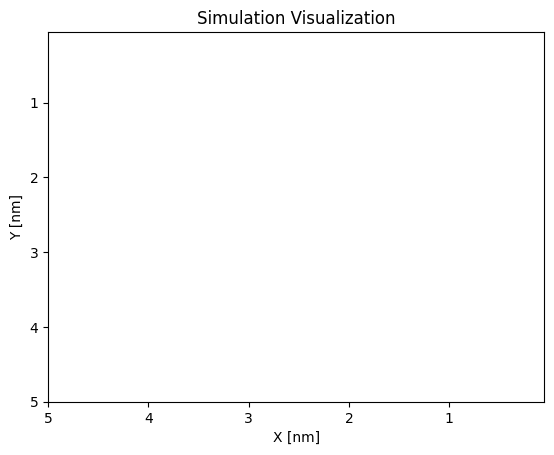

In [74]:
n_particles : int = 50
spacing : float = 8/5
paritcle_mass : float = 18  # g/mol 
velocity : float = 150 #  nm/ns
time_steps :int = 500
dt :float = 0.002  # ns
box : tuple[int, int] = (5,5)
data : NDArray[np.float64] = np.zeros((time_steps,len(box)**2,n_particles)) # (Time, len(x,y,vx,vy), N)

data = simulate(
    initialize_particles_on_grid(
    n_particles=n_particles,
    spacing=spacing,
    mass=paritcle_mass,  
    velocity=velocity  
    ),
    time=time_steps,  # timesteps
    dt=dt,  # ns
    box=box,
    data=data  # Time, phase-space pp, particles
)

creat_animation("sheet02-animation1",box, data[:,0,:],data[:,1,:])